In [1]:
from google.colab import files
uploaded = files.upload()

Saving bee_imgs.zip to bee_imgs.zip


In [2]:
import zipfile
import io

# Descomprimir el archivo ZIP
data = zipfile.ZipFile(io.BytesIO(uploaded['bee_imgs.zip']), 'r')
data.extractall()

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

**Cargar y explorar el CSV**

In [4]:

csv_path = '/content/bee_data.csv'
data = pd.read_csv(csv_path)
print(data.head())

          file     date   time        location  zip code subspecies  \
0  041_066.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
1  041_072.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
2  041_073.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
3  041_067.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
4  041_059.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   

              health  pollen_carrying   caste  
0  hive being robbed            False  worker  
1  hive being robbed            False  worker  
2  hive being robbed            False  worker  
3  hive being robbed            False  worker  
4  hive being robbed            False  worker  


**Preprocesamiento de imágenes**

In [5]:

image_path = '/content/bee_imgs/'

**Filtrar las imágenes disponibles en la carpeta**

In [6]:
available_files = set(os.listdir(image_path))
data = data[data['file'].isin(available_files)]

**Explorar las etiquetas de salud**

In [7]:
print(data['health'].unique())

['hive being robbed' 'healthy' 'few varrao, hive beetles' 'ant problems'
 'missing queen' 'Varroa, Small Hive Beetles']


**Convertir las etiquetas a categorías binarias (0 = enfermo, 1 = sano)**

In [9]:
def convert_health_label(health):
    unhealthy_conditions = ['hive being robbed', 'few varrao, hive beetles', 'ant problems', 'Varroa, Small Hive Beetles']
    return 0 if health in unhealthy_conditions else 1

data['health'] = data['health'].apply(convert_health_label)

In [10]:
img_size = (44, 64)

**Cargar imágenes**

In [12]:

def load_image(file):
    img = load_img(image_path + file, target_size=img_size)
    img = img_to_array(img)
    img = img / 255.0
    return img

# Aplicar la función a todas las imágenes
data['image'] = data['file'].apply(load_image)

**Dividir los datos en conjuntos de entrenamiento, validación y prueba**

In [13]:
X = np.stack(data['image'])
y = data['health'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Construcción del Modelo**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(44, 64, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 42, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 19, 29, 64)        256       
 chNormalization)                                                
                                                        

**Entrenamiento del Modelo**

In [22]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/100
95/95 [==============================] - 23s 240ms/step - loss: 0.0087 - accuracy: 0.9977 - val_loss: 0.1353 - val_accuracy: 0.9713
Epoch 2/100
95/95 [==============================] - 19s 197ms/step - loss: 0.0233 - accuracy: 0.9944 - val_loss: 0.7747 - val_accuracy: 0.8533
Epoch 3/100
95/95 [==============================] - 19s 198ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.2180 - val_accuracy: 0.9693
Epoch 4/100
95/95 [==============================] - 21s 221ms/step - loss: 0.0033 - accuracy: 0.9987 - val_loss: 0.1627 - val_accuracy: 0.9693
Epoch 5/100
95/95 [==============================] - 18s 195ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.1163 - val_accuracy: 0.9841
Epoch 6/100
95/95 [==============================] - 19s 204ms/step - loss: 0.0027 - accuracy: 0.9983 - val_loss: 0.1118 - val_accuracy: 0.9812
Epoch 7/100
95/95 [==============================] - 20s 210ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.2502 - val_accuracy:

**Graficas**

In [ ]:

def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

**Evaluación del Modelo**

32/32 [==============================] - 1s 43ms/step - loss: 0.1201 - accuracy: 0.9861
Test Accuracy: 0.986138641834259
32/32 [==============================] - 3s 88ms/step


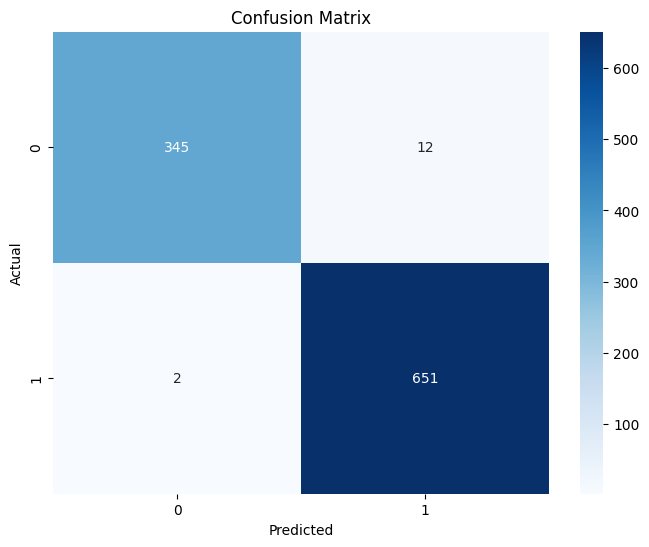

              precision    recall  f1-score   support

   Unhealthy       0.99      0.97      0.98       357
     Healthy       0.98      1.00      0.99       653

    accuracy                           0.99      1010
   macro avg       0.99      0.98      0.98      1010
weighted avg       0.99      0.99      0.99      1010



In [24]:
# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Unhealthy', 'Healthy']))


**Predicción**


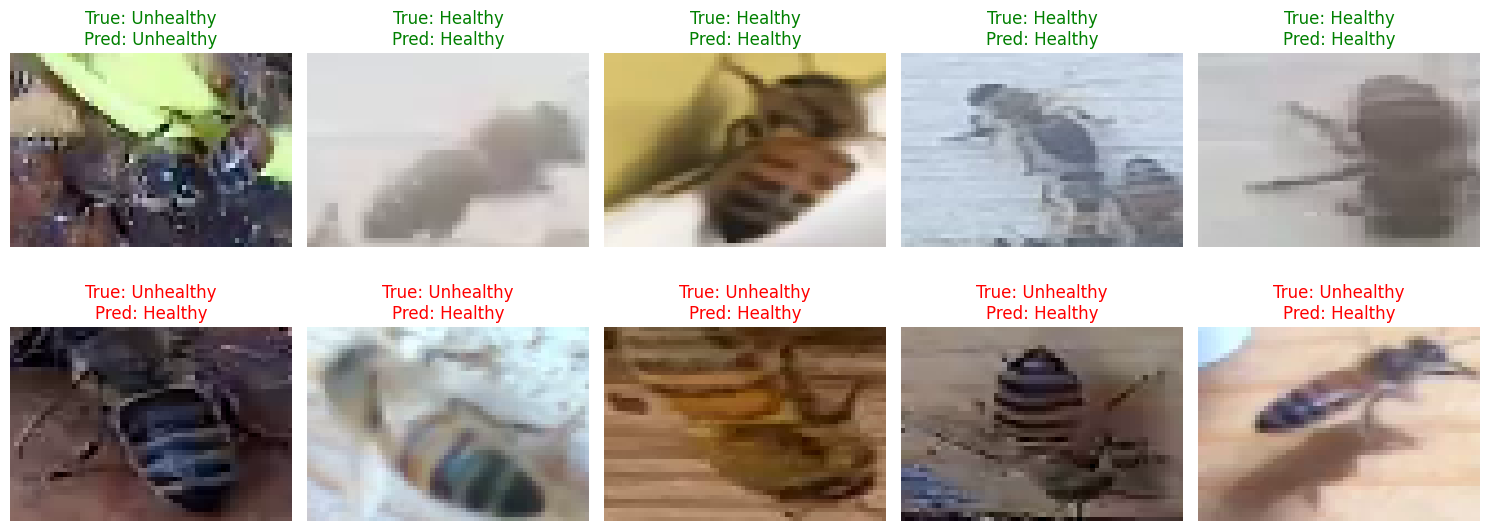

In [30]:
def visualize_predictions(X, y_true, y_pred, num_images=5):
    incorrect = np.where(y_true != y_pred)[0]
    correct = np.where(y_true == y_pred)[0]

    plt.figure(figsize=(15, 6))

    for i, idx in enumerate(correct[:num_images]):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[idx])
        title = f'True: {"Healthy" if y_true[idx] == 1 else "Unhealthy"}\nPred: {"Healthy" if y_pred[idx] == 1 else "Unhealthy"}'
        plt.title(title, color='green')
        plt.axis('off')

    for i, idx in enumerate(incorrect[:num_images]):
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(X[idx])
        title = f'True: {"Healthy" if y_true[idx] == 1 else "Unhealthy"}\nPred: {"Healthy" if y_pred[idx] == 1 else "Unhealthy"}'
        plt.title(title, color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ejecutar la función de visualización con ejemplos de predicciones
visualize_predictions(X_test, y_test, y_pred.flatten())

